## Upload datasets

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df_unclassified = pd.read_csv('/kaggle/input/caspianreport-comments-llm-classified/youtube_comments.csv')
df_classified = pd.read_csv('/kaggle/input/caspianreport-comments-llm-classified/comments_classified.csv')

## Checking attitude

Code for distribution diagrams

In [3]:
# Create attitude categories based on your criteria
def categorize_attitude(value, confidence):
    # Not mentioned: NaN or low confidence
    if pd.isna(value) or confidence <= 0.6:
        return 'Not mentioned'
    # Positive: >6 with high confidence
    elif value > 6 and confidence > 0.6:
        return 'Positive'
    # Negative: <5 with high confidence
    elif value < 5 and confidence > 0.6:
        return 'Negative'
    # Neutral: 5-6 with high confidence
    else:
        return 'Neutral'

In [4]:
df_classified['israel_attitude_category'] = df_classified.apply(lambda row: categorize_attitude(row['attitude_towards_israel'], row['attitude_confidence']), axis=1)
df_classified['us_attitude_category'] = df_classified.apply(lambda row: categorize_attitude(row['attitude_towards_us'], row['attitude_confidence']), axis=1)
df_classified['quatar_attitude_category'] = df_classified.apply(lambda row: categorize_attitude(row['attitude_towards_qatar'], row['attitude_confidence']), axis=1)
df_classified['hamas_attitude_category'] = df_classified.apply(lambda row: categorize_attitude(row['attitude_towards_hamas'], row['attitude_confidence']), axis=1)

In [5]:
def draw_attitude_distribution_diagram(title, category_name):
    # Count categories
    attitude_counts = df_classified[category_name].value_counts()
    
    # Create pie chart
    plt.figure(figsize=(10, 8))
    
    # Fixed color names - use valid matplotlib colors
    colors = ['lightgray', 'crimson', 'forestgreen', 'gold']
    explode = tuple([0.05] * len(attitude_counts))  # dynamically sized explode
    
    wedges, texts, autotexts = plt.pie(attitude_counts.values, 
                                      labels=attitude_counts.index,
                                      colors=colors[:len(attitude_counts)],  # match colors to data
                                      autopct='%1.1f%%',
                                      startangle=90,
                                      explode=explode[:len(attitude_counts)],  # match explode to data
                                      textprops={'fontsize': 12})
    
    # Enhance the appearance
    plt.title(title, 
              fontsize=14, fontweight='bold', pad=20)
    
    # Add count labels
    for i, (category, count) in enumerate(attitude_counts.items()):
        plt.text(0, -1.3 + i*0.1, f'{category}: {count} comments', 
                 fontsize=10, ha='center')
    
    plt.axis('equal')
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("Attitude Distribution Summary:")
    print(f"Total comments: {len(df_classified)}")
    for category, count in attitude_counts.items():
        percentage = (count / len(df_classified)) * 100
        print(f"{category}: {count} comments ({percentage:.1f}%)")

Code for cluster summary

Initializing DSPy

In [10]:
import dspy
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
OPENAI_BASE_URL= 'https://api.openai.com/v1'
OPENAI_API_KEY = user_secrets.get_secret("OPENAI_API_KEY")
lm = dspy.LM("openai/gpt-5", api_key=OPENAI_API_KEY, api_base=OPENAI_BASE_URL, temperature=1.0, max_tokens=16000)
dspy.configure(lm=lm)

Summarizing video

In [20]:
from IPython.display import Markdown
with open('/kaggle/input/caspianreport-comments-llm-classified/video_transcript.md', 'r', encoding='utf-8') as f:
    transcript = f.read()
summarize = dspy.ChainOfThought('document -> summary')
response = summarize(document=transcript)
video_summary = response.summary
Markdown(video_summary)

The video argues Israel crossed a red line by striking Hamas leaders in Doha, Qatar—missing top targets but killing several officials—and in doing so crippled ceasefire talks and shattered assumptions about safe havens and US protection. Qatar, long the hub for mediation and host to the US Al-Udeid base, now faces accusations of being unable to safeguard interlocutors. The narrator contends the operation’s range and stealth constraints imply in-flight refueling, likely via US assets, and that alternate theories (e.g., UK tanker support or Red Sea/ALBM profiles) still point to inevitable US detection if not tacit approval. Qatar’s sophisticated air defenses did not engage, suggesting prior awareness or pressure—though this remains unverified. Conflicting accounts over US warnings deepen suspicion, and Hamas accuses Washington of complicity after a Trump-urged meeting preceded the strike; media coverage is portrayed as uneven. Strategically, the attack further weakens Qatar’s mediation (already faltering since late 2024), hardens Hamas’s stance, and may prompt Doha to expel Hamas leaders, shifting mediation to Egypt/US with limited leverage. The episode also underscores the perceived emptiness of US security guarantees after both Iranian and Israeli strikes, pushing Qatar to hedge with Turkey and closer ties to Saudi/UAE.

In [85]:
with open('/kaggle/working/video_summary.md', 'w', encoding='utf-8') as f:
    f.write(video_summary)

Defining signature for cluster summarization

In [21]:
from typing import List, Literal

class AnalyzeAttitudeBiasedCluster(dspy.Signature):
    """
    Analyze a cluster of YouTube comments that share similar attitudes toward a specific entity (Israel, US, Qatar, or Hamas).
    
    Identify common patterns in how these attitudes are expressed, the underlying reasons for these attitudes,
    and the linguistic/rhetorical strategies used. Focus on understanding WHY these commenters share similar
    attitudes and HOW they express them.
    
    Look for:
    1. Common underlying beliefs or assumptions
    2. Shared experiences or reference points
    3. Similar information sources or narratives
    4. Recurring linguistic patterns or emotional expressions
    5. Consistent reasoning frameworks or justifications
    """

    # Input fields
    comments_content: List[str] = dspy.InputField(
        desc="List of comment text content from the cluster (100 comments max)"
    )
    
    target_entity: Literal['Israel', 'US', 'Qatar', 'Hamas'] = dspy.InputField(
        desc="The entity toward which the cluster shows biased attitude"
    )

    attitude_direction: Literal['positive', 'negative'] = dspy.InputField(
        desc="Whether the cluster shows positive or negative attitude toward the target entity"
    )
    
    attitude_intensity: Literal['strong', 'moderate'] = dspy.InputField(
        desc="Intensity level of the shared attitude (based on original attitude scores)"
    )

    video_summary: str = dspy.InputField(
        desc="Comprehensive summary of the video content providing context for analysis"
    )

    # Output fields
    cluster_summary: str = dspy.OutputField(
        desc="Comprehensive structured analysis of the attitude-biased comment cluster"
    )

    key_insights: List[str] = dspy.OutputField(
        desc="3-5 most important insights about why this cluster shares similar attitudes"
    )

    representative_quotes: List[str] = dspy.OutputField(
        desc="2-3 actual comment excerpts that best represent the cluster's attitude patterns"
    )    

In [22]:
summarize_attitude = dspy.ChainOfThought(AnalyzeAttitudeBiasedCluster)

Form cluster based on features and run summarization

In [76]:
def get_cluster_summary(comments_df, target_entity: str, sample_size=50, attitude_threshold: float = 7.0):
    """
    Analyze attitude clusters from a DataFrame of comments.
    
    Args:
        comments_df: Pandas DataFrame with comment data
        target_entity: 'israel', 'us', 'qatar', or 'hamas'
        attitude_threshold: Minimum attitude score to include in cluster (1-10 scale)
    """
    
    # Filter comments based on attitude toward target entity
    attitude_col = f'attitude_towards_{target_entity.lower()}'
    
    # Get positive cluster (attitude >= attitude_threshold)
    positive_cluster = comments_df[
        (comments_df[attitude_col] >= attitude_threshold) & 
        (comments_df['attitude_confidence'] >= 0.7)
    ].sample(sample_size)['content'].tolist()
    
    # Get negative cluster (attitude <= 10 - attitude_threshold)
    negative_cluster = comments_df[
        (comments_df[attitude_col] <= (10 - attitude_threshold)) & 
        (comments_df['attitude_confidence'] >= 0.7)
    ].sample(sample_size)['content'].tolist()

    results = {}
        
    # Analyze positive cluster if it exists
    if len(positive_cluster) >= 5:  # Minimum cluster size
        positive_sample = positive_cluster
        
        positive_analysis = summarize_attitude(
            comments_content=positive_sample,
            target_entity=target_entity.title(),
            attitude_direction='positive',
            attitude_intensity='strong' if attitude_threshold >= 8 else 'moderate',
            video_summary=video_summary
        )
        results['positive_cluster'] = positive_analysis
    
    # Analyze negative cluster if it exists
    if len(negative_cluster) >= 5:  # Minimum cluster size
        negative_sample = negative_cluster
        
        negative_analysis = summarize_attitude(
            comments_content=negative_sample,
            target_entity=target_entity.title(),
            attitude_direction='negative',
            attitude_intensity='strong' if attitude_threshold >= 8 else 'moderate',
            video_summary=video_summary
        )
        results['negative_cluster'] = negative_analysis
        
    return results

### Towards Israel

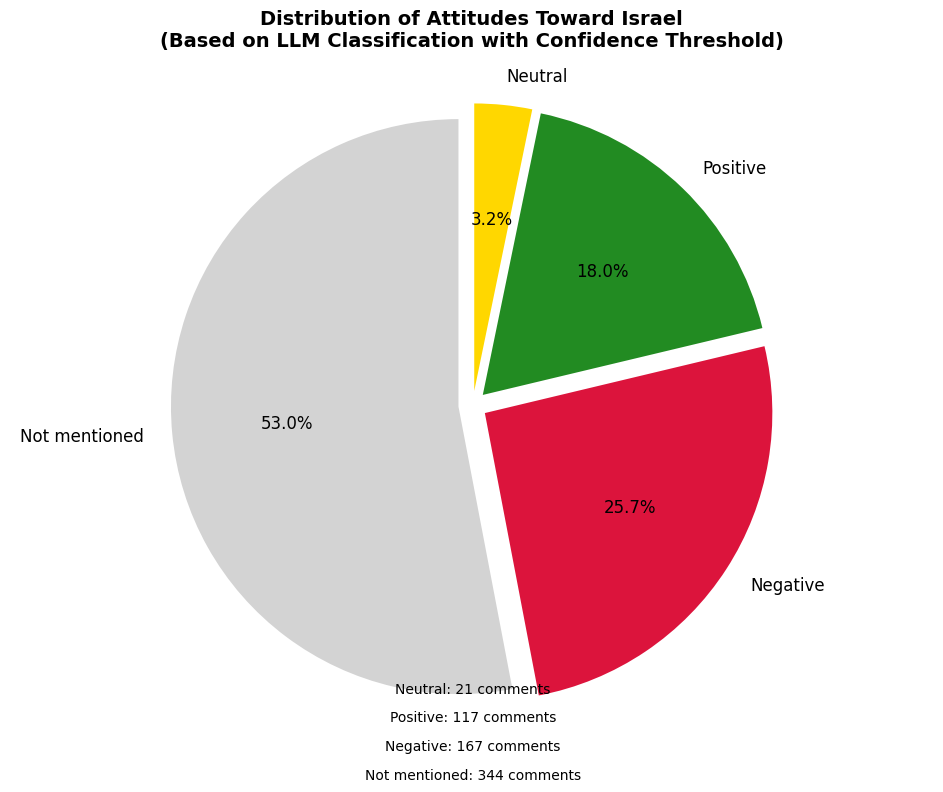

Attitude Distribution Summary:
Total comments: 649
Not mentioned: 344 comments (53.0%)
Negative: 167 comments (25.7%)
Positive: 117 comments (18.0%)
Neutral: 21 comments (3.2%)


In [6]:
title = 'Distribution of Attitudes Toward Israel\n(Based on LLM Classification with Confidence Threshold)'
draw_attitude_distribution_diagram(title, 'israel_attitude_category')

## 🇮🇱 Complete Attitude Analysis: Israel

In [27]:
israel_attitude_summary = get_cluster_summary(df_classified, 'israel')

/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less_equal
  return op(a, b)


Next cell represents formatting logic - code been generated with AI - feel free to skip it

In [51]:
class AttitudeAnalysisPresenter:
    """Class for presenting attitude analysis results in Jupyter notebooks with rich formatting."""
    
    def __init__(self):
        self.emoji_map = {
            'Israel': '🇮🇱',
            'US': '🇺🇸', 
            'Qatar': '🇶🇦',
            'Hamas': '🏴',
            'positive': '👍',
            'negative': '👎',
            'strong': '🔥',
            'moderate': '📊'
        }
        
        self.attitude_colors = {
            'strongly_positive': '#28a745',
            'moderately_positive': '#6f42c1', 
            'strongly_negative': '#dc3545',
            'moderately_negative': '#fd7e14'
        }

    
    def _format_cluster_summary(self, cluster_summary: str) -> str:
        """Format the cluster summary text with better structure."""
        if not cluster_summary:
            return "*No detailed summary available*"
        
        # Split by bullet points or dashes and format nicely
        lines = cluster_summary.split('\n')
        formatted_lines = []
        
        for line in lines:
            line = line.strip()
            if line.startswith('-'):
                # Format bullet points with better styling
                formatted_lines.append(f"**•** {line[1:].strip()}")
            elif line and not line.startswith(' '):
                # Format headers
                if ':' in line:
                    parts = line.split(':', 1)
                    formatted_lines.append(f"**{parts[0].strip()}:** {parts[1].strip()}")
                else:
                    formatted_lines.append(line)
            elif line:
                # Indent sub-points
                formatted_lines.append(f"  {line.strip()}")
        
        return '\n\n'.join(formatted_lines)
    
    def _extract_themes_from_reasoning(self, reasoning: str) -> List[str]:
        """Extract key themes from reasoning text for display."""
        if not reasoning:
            return []
        
        # Simple extraction of key concepts (you can make this more sophisticated)
        themes = []
        key_phrases = ['Hamas', 'Qatar', 'Israel', 'mediation', 'ceasefire', 'sovereignty', 
                      'diplomacy', 'terrorism', 'peace talks', 'strike', 'borders']
        
        for phrase in key_phrases:
            if phrase.lower() in reasoning.lower():
                themes.append(phrase)
        
        return themes[:5]  # Limit to top 5import pandas as pd
    
    def present_single_cluster(self, analysis_result, cluster_type: str = "Cluster", target_entity: str = "", attitude_direction: str = ""):
        """Present analysis results for a single attitude cluster."""
        
        # Extract the analysis components - your data format uses different field names
        reasoning = getattr(analysis_result, 'reasoning', '')
        cluster_summary = getattr(analysis_result, 'cluster_summary', '')
        key_insights = getattr(analysis_result, 'key_insights', [])
        representative_quotes = getattr(analysis_result, 'representative_quotes', [])
        
        # Get emoji and styling
        entity_emoji = self.emoji_map.get(target_entity, '🎯')
        attitude_emoji = self.emoji_map.get(attitude_direction, '💭')
        intensity_emoji = '🔥'  # Default to strong since your data shows strong attitudes
        
        # Determine color based on cluster type
        if 'positive' in cluster_type.lower():
            attitude_color = self.attitude_colors.get('strongly_positive', '#28a745')
        else:
            attitude_color = self.attitude_colors.get('strongly_negative', '#dc3545')
        
        # Create the markdown content
        markdown_content = f"""
# {entity_emoji} Attitude Analysis: {target_entity}
## {attitude_emoji} {attitude_direction.title()} {intensity_emoji} Cluster Analysis

<div style="background-color: {attitude_color}15; padding: 15px; border-left: 4px solid {attitude_color}; margin: 10px 0;">
<strong>Cluster Type:</strong> {cluster_type.replace('_', ' ').title()}<br>
<strong>Analysis Quality:</strong> Comprehensive reasoning provided
</div>

---

## 🧠 **AI Reasoning Summary**

<div style="padding: 15px; border-radius: 8px; margin: 15px 0; border-left: 3px solid #007bff;">
<em>{reasoning}</em>
</div>

---

## 🎯 **Key Insights**
"""
        
        # Add key insights
        if key_insights:
            for i, insight in enumerate(key_insights, 1):
                markdown_content += f"\n**{i}.** {insight}\n"
        else:
            markdown_content += "\n*Key insights extracted from the reasoning above.*\n"
        
        # Add cluster summary section
        markdown_content += f"""
---

## 📋 **Detailed Cluster Analysis**

<div style="padding: 15px; border-radius: 8px; line-height: 1.6;">
{self._format_cluster_summary(cluster_summary)}
</div>

---

## 💬 **Representative Quotes**
"""
        
        # Add representative quotes
        if representative_quotes:
            for i, quote in enumerate(representative_quotes, 1):
                markdown_content += f"""
> **Quote {i}:** *"{quote}"*

"""
        else:
            markdown_content += "\n*Representative quotes are embedded in the analysis above.*\n"
        
        # Add footer
        markdown_content += f"""
---
<small>Analysis generated on {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}</small>
"""
        
        # Display the markdown
        display(Markdown(markdown_content))
    
    def present_dual_clusters(self, analysis_results: Dict, target_entity: str):
        """Present both positive and negative clusters side by side."""
        
        entity_emoji = self.emoji_map.get(target_entity, '🎯')
        
        # Header
        header_md = f"""
# {entity_emoji} Complete Attitude Analysis: {target_entity}

<div style="text-align: center; background: linear-gradient(90deg, #28a74520, #dc354520); padding: 20px; border-radius: 10px; margin: 20px 0;">
<h2>Comprehensive Analysis of Positive vs Negative Attitude Clusters</h2>
</div>

---
"""
        display(Markdown(header_md))
        
        # Present each cluster
        if 'positive_cluster' in analysis_results:
            self.present_single_cluster(
                analysis_results['positive_cluster'], 
                "Positive Cluster", 
                target_entity,
                "positive"
            )
            display(Markdown("---\n"))
        
        if 'negative_cluster' in analysis_results:
            self.present_single_cluster(
                analysis_results['negative_cluster'], 
                "Negative Cluster",
                target_entity,
                "negative"
            )
        
        # Summary comparison if both clusters exist
        if 'positive_cluster' in analysis_results and 'negative_cluster' in analysis_results:
            self._present_cluster_comparison(analysis_results, target_entity)
    
    def _present_cluster_comparison(self, analysis_results: Dict, target_entity: str):
        """Create a side-by-side comparison of positive and negative clusters."""
        
        pos_analysis = analysis_results['positive_cluster']
        neg_analysis = analysis_results['negative_cluster']
        
        # Extract key insights counts
        pos_insights_count = len(getattr(pos_analysis, 'key_insights', []))
        neg_insights_count = len(getattr(neg_analysis, 'key_insights', []))
        
        # Extract quote counts  
        pos_quotes_count = len(getattr(pos_analysis, 'representative_quotes', []))
        neg_quotes_count = len(getattr(neg_analysis, 'representative_quotes', []))
        
        comparison_md = f"""
---

# 🔍 **Cluster Comparison Summary**

<div style="display: flex; gap: 20px; margin: 20px 0;">

<div style="flex: 1; background-color: #28a74510; padding: 15px; border-radius: 8px;">
<h3 style="color: #28a745;">👍 Positive Cluster</h3>
<strong>Key Insights:</strong> {pos_insights_count}<br>
<strong>Quotes:</strong> {pos_quotes_count}<br>
<strong>Analysis Quality:</strong> Comprehensive reasoning provided
</div>

<div style="flex: 1; background-color: #dc354510; padding: 15px; border-radius: 8px;">
<h3 style="color: #dc3545;">👎 Negative Cluster</h3>
<strong>Key Insights:</strong> {neg_insights_count}<br>
<strong>Quotes:</strong> {neg_quotes_count}<br>
<strong>Analysis Quality:</strong> Comprehensive reasoning provided
</div>

</div>

## 🎯 **Key Contrasts**

### Core Justifications
"""
        
        # Extract key themes from reasoning for comparison
        pos_reasoning = getattr(pos_analysis, 'reasoning', '')[:200] + "..."
        neg_reasoning = getattr(neg_analysis, 'reasoning', '')[:200] + "..."
        
        comparison_md += f"""
- **Positive:** {pos_reasoning}
- **Negative:** {neg_reasoning}

### Representative Arguments
"""
        
        # Get first quotes from each cluster for comparison
        pos_quotes = getattr(pos_analysis, 'representative_quotes', [])
        neg_quotes = getattr(neg_analysis, 'representative_quotes', [])
        
        if pos_quotes:
            comparison_md += f"\n- **Positive:** *\"{pos_quotes[0]}\"*"
        if neg_quotes:
            comparison_md += f"\n- **Negative:** *\"{neg_quotes[0]}\"*"
            
        comparison_md += "\n\n---\n"
        
        display(Markdown(comparison_md))
    
    def present_multiple_entities(self, all_results: Dict[str, Dict]):
        """Present analysis results for multiple entities in a dashboard format."""
        
        dashboard_md = f"""
# 🌍 **Multi-Entity Attitude Analysis Dashboard**

<div style="text-align: center; background: linear-gradient(135deg, #667eea 0%, #764ba2 100%); color: white; padding: 20px; border-radius: 10px; margin: 20px 0;">
<h2>Comprehensive Geopolitical Sentiment Analysis</h2>
<p>Analysis of attitude patterns across multiple entities from YouTube comments</p>
</div>

---
"""
        display(Markdown(dashboard_md))
        
        # Create entity summary table
        summary_data = []
        for entity, results in all_results.items():
            for cluster_type, analysis in results.items():
                if hasattr(analysis, 'key_insights'):
                    summary_data.append({
                        'Entity': f"{self.emoji_map.get(entity, '🎯')} {entity}",
                        'Attitude': cluster_type.replace('_cluster', '').title(),
                        'Key Insights': len(getattr(analysis, 'key_insights', [])),
                        'Quotes': len(getattr(analysis, 'representative_quotes', [])),
                        'Has Reasoning': 'Yes' if getattr(analysis, 'reasoning', '') else 'No'
                    })
        
        if summary_data:
            summary_df = pd.DataFrame(summary_data)
            display(Markdown("## 📊 **Summary Overview**"))
            display(summary_df)
            display(Markdown("---"))
        
        # Present each entity's analysis
        for entity, results in all_results.items():
            if results:  # Only if there are results for this entity
                self.present_dual_clusters(results, entity)
                display(Markdown("\n" + "="*80 + "\n"))
    
    def _format_list_as_bullets(self, items: List[str]) -> str:
        """Format a list as markdown bullets."""
        if not items:
            return "*No items found*"
        return '\n'.join([f"- {item}" for item in items])
    
    def _format_list_as_badges(self, items: List[str]) -> str:
        """Format a list as colored badges."""
        if not items:
            return "*No themes identified*"
        
        badges = []
        colors = ['#007bff', '#28a745', '#ffc107', '#dc3545', '#6f42c1', '#20c997']
        
        for i, item in enumerate(items):
            color = colors[i % len(colors)]
            badge = f'<span style="background-color: {color}; color: white; padding: 4px 8px; border-radius: 12px; font-size: 0.8em; margin: 2px;">{item}</span>'
            badges.append(badge)
        
        return ' '.join(badges)
    
    def _create_confidence_bar(self, confidence: float) -> str:
        """Create a visual confidence bar."""
        width = int(confidence * 100)
        color = '#28a745' if confidence >= 0.7 else '#ffc107' if confidence >= 0.4 else '#dc3545'
        
        return f"""
<div style="background-color: #e9ecef; border-radius: 10px; overflow: hidden; height: 20px; width: 200px; display: inline-block;">
    <div style="background-color: {color}; height: 100%; width: {width}%; display: flex; align-items: center; justify-content: center; color: white; font-size: 0.8em; font-weight: bold;">
        {confidence:.2f}
    </div>
</div>
"""

    def export_to_html(self, analysis_results, filename: str = "attitude_analysis.html"):
        """Export the analysis to an HTML file."""
        # This would create an HTML export of the analysis
        # Implementation depends on your specific needs
        pass


In [52]:
presenter = AttitudeAnalysisPresenter()

In [53]:
presenter.present_dual_clusters(israel_attitude_summary, 'Israel')


# 🇮🇱 Complete Attitude Analysis: Israel

<div style="text-align: center; background: linear-gradient(90deg, #28a74520, #dc354520); padding: 20px; border-radius: 10px; margin: 20px 0;">
<h2>Comprehensive Analysis of Positive vs Negative Attitude Clusters</h2>
</div>

---



# 🇮🇱 Attitude Analysis: Israel
## 👍 Positive 🔥 Cluster Analysis

<div style="background-color: #28a74515; padding: 15px; border-left: 4px solid #28a745; margin: 10px 0;">
<strong>Cluster Type:</strong> Positive Cluster<br>
<strong>Analysis Quality:</strong> Comprehensive reasoning provided
</div>

---

## 🧠 **AI Reasoning Summary**

<div style="padding: 15px; border-radius: 8px; margin: 15px 0; border-left: 3px solid #007bff;">
<em>The comments consistently defend Israel’s strike on Hamas leaders in Doha and portray Qatar as a longtime sponsor and enabler of Hamas and wider Islamist militancy. The core justification is a “no safe havens” self‑defense doctrine: if a state harbors terrorist leaders who targeted Israeli civilians on Oct 7, Israel is warranted in pursuing them across borders. Commenters dispute the video’s framing that Israel “crossed a red line,” instead arguing that Qatar’s duplicity as both mediator and benefactor invalidates its neutrality and makes consequences inevitable. Rhetorically, they use moral and causal frames (actions have consequences), analogies (Al‑Qaeda leaders in Cuba), and delegitimization of Qatar’s media (Al Jazeera) and soft power. A minority voice expresses conditional support (target leaders but avoid civilian casualties), slightly moderating the overall intensity.</em>
</div>

---

## 🎯 **Key Insights**

**1.** A shared “no safe havens” doctrine underpins support for cross‑border targeting of Hamas leaders, outweighing concerns about sovereignty or diplomatic fallout.

**2.** Qatar is widely perceived as a non‑neutral actor—financier, host, and propagandist for Hamas—so consequences for Doha are framed as deserved and long overdue.

**3.** Oct 7 serves as the core moral touchstone, used to justify extraordinary measures and cast Israeli actions as defensive necessity.

**4.** Delegitimization of Qatari media (especially Al Jazeera) and claims of influence over Western institutions reinforce distrust of narratives critical of Israel.

**5.** Analogies to US counterterrorism (e.g., Al‑Qaeda in Cuba) normalize Israel’s actions and provide a familiar Western security logic.

---

## 📋 **Detailed Cluster Analysis**

<div style="padding: 15px; border-radius: 8px; line-height: 1.6;">
**•** Orientation: Pro‑Israel, approving of the Doha strike and broader “no safe haven” policy. Israel is framed as acting in justified self‑defense and following through on its pledge to dismantle Hamas post‑Oct 7.

**•** Target of criticism: Qatar is cast as Hamas’s banker/host, propagandist, and bad‑faith mediator. Al Jazeera is labeled a propaganda arm. Some also critique the US as unreliable or complicit, but this is secondary to justifying Israel’s action.

**•** Core justifications:

**•** Moral reciprocity and deterrence: after Hamas’s mass‑casualty attack on civilians, its leaders “deserve” to be targeted anywhere they hide.

**•** Principle over borders: international borders are seen as less binding when terrorist groups violate them; thus extraterritorial strikes are acceptable.

**•** Delegitimizing Qatar’s mediation: a mediator that funds/shelters one side cannot be neutral; pressure/strikes are portrayed as overdue and necessary to force outcomes (e.g., hostages).

**•** Comparative analogy: US would have struck Al‑Qaeda leaders on foreign soil; therefore Israel’s action is normal state behavior.

**•** Rhetorical patterns:

**•** Causal maxims and aphorisms (“lie with dogs, get fleas”), mockery of Hamas, celebratory/emotive language and emojis, religious citation to frame duplicity, and repeated “no safe haven” refrain.

**•** Quantification and specifics (Oct 7 casualty counts; “banker of terror”) to bolster moral clarity.

**•** Media distrust: claims of a Qatari “propaganda machine” shaping Western academia/media.

**•** Engagement with the video: Many reject the thesis that Israel crippled diplomacy; they argue Qatar was already obstructive or weaponizing mediation. Some imply US awareness of the strike but view that as either irrelevant or vindicating.

**•** Intra‑cluster nuance: One Israeli commenter supports the operation but calls for apologies/compensation for Qatari civilian deaths—showing conditional support that tempers the cluster’s intensity from “strong” to “moderate.”
</div>

---

## 💬 **Representative Quotes**

> **Quote 1:** *"If you're a country that is harboring literal terrorist organization leaders, don't be surprised if you get a targeted strike within your borders."*


> **Quote 2:** *"Qatar is the banker of Hamas and most other terrorist groups in the Middle East... they had this coming and it is long overdue."*


> **Quote 3:** *"Why should Israel respect international borders when it's terrorist enemies don't?"*


---
<small>Analysis generated on 2025-09-18 17:09:27</small>


---



# 🇮🇱 Attitude Analysis: Israel
## 👎 Negative 🔥 Cluster Analysis

<div style="background-color: #dc354515; padding: 15px; border-left: 4px solid #dc3545; margin: 10px 0;">
<strong>Cluster Type:</strong> Negative Cluster<br>
<strong>Analysis Quality:</strong> Comprehensive reasoning provided
</div>

---

## 🧠 **AI Reasoning Summary**

<div style="padding: 15px; border-radius: 8px; margin: 15px 0; border-left: 3px solid #007bff;">
<em>Across comments, Israel is consistently framed as sabotaging peace, violating international norms, and acting with impunity—often with alleged U.S. complicity. Users cite the Doha strike during talks, alleged ceasefire breaches, historic assassinations, and attacks on Iran/Hezbollah as part of a recurring pattern that “proves” Israel doesn’t want negotiations or peace. They generalize from these incidents to broader claims (rogue/criminal state, imperialism), express distrust of U.S. security guarantees and mainstream media, and infer ulterior motives (Netanyahu’s self-preservation, U.S. power projection). Linguistically, they use categorical statements, moral absolutism, analogies (mafia/cartel), sarcasm, and calls to isolate/sanction Israel. The video’s thesis about red lines, U.S. detection/approval, and Qatar’s compromised mediation provides a backbone that commenters use to justify their negative judgments. A few comments veer into conspiratorial or dehumanizing rhetoric, but the central throughline is that striking mediators during negotiations delegitimizes Israel’s claims to seek peace.</em>
</div>

---

## 🎯 **Key Insights**

**1.** Attacking during mediation is interpreted as decisive evidence that Israel prefers coercion over diplomacy, reinforcing a long-held belief that it systematically sabotages peace.

**2.** Commenters view the U.S. as complicit or enabling—through detection, refueling, or political cover—eroding trust in U.S. security guarantees and amplifying anger at Israel.

**3.** A historical-pattern narrative (from 1948 to Iran/Hezbollah episodes) is used to generalize current actions into a durable claim that Israel is a rogue/bad-faith actor.

**4.** Moral and delegitimizing language (rogue state, crime syndicate, genocide) and sarcasm serve to signal outrage and justify calls for isolation or sanctions.

**5.** Distrust of mainstream media and international institutions strengthens in-group consensus that double standards protect Israel from accountability.

---

## 📋 **Detailed Cluster Analysis**

<div style="padding: 15px; border-radius: 8px; line-height: 1.6;">
**•** Attitude and target: The cluster expresses a negative view of Israel, portraying it as a bad-faith actor that undermines peace, violates sovereignty, and cannot be trusted.

**•** Core claims:

**•** Israel attacks during or around negotiations, implying it prefers force over diplomacy (“standard for Israel,” “doesn’t want peace”).

**•** The Doha strike is seen as a red-line breach and a betrayal of mediation efforts, damaging ceasefire prospects and regional norms.

**•** The U.S. is viewed as complicit or enabling (refueling, detection, unreliable guarantees), eroding trust in American security commitments.

**•** Israel operates as a “rogue/criminal” state, with double standards in international law and media bias protecting it.

**•** Justifications and reference points:

**•** Specific events: strike in Qatar during talks; claims Israel broke a ceasefire; historic references (UN mediator in 1948, Nasrallah, surprise attacks on Iran).

**•** Institutional/structural arguments: use of others’ airspace, failure of air defenses to engage, perceived U.S. approval or awareness.

**•** Moral-normative reasoning: attacking mediators = proof of bad faith; bombing sovereign states = act of war; thus Israel should be isolated/outcast.

**•** Rhetorical patterns:

**•** Absolutist framing (“always,” “never”), moral condemnation (“disgusting,” “crime syndicate,” “war mongering”), and delegitimizing labels (“rogue state”).

**•** Sarcasm/paradox (“Israel: bomb baby bomb… we want peace”), appeals to international law and UN action, and skepticism of media narratives.

**•** Some conspiratorial inference (U.S.–Israel ambush) and personalized blame (Netanyahu thrives on war).

**•** Why they share this attitude:

**•** The perceived violation—striking negotiators/mediators—confirms prior beliefs that Israel systematically undermines peace.

**•** The episode fits an existing narrative of double standards and impunity backed by the U.S., intensifying distrust in both.

**•** Emotional salience: moral outrage at harming mediation and civilians, and frustration with what commenters see as media underreporting or bias.

**•** Relationship to the video:

**•** The video’s emphasis on U.S. detection/tacit approval, Qatar’s compromised role, and weakened ceasefire leverage aligns with commenters’ claims of Israeli bad faith and U.S. complicity, reinforcing their negative evaluations.
</div>

---

## 💬 **Representative Quotes**

> **Quote 1:** *"I can't think of a bigger betrayal than Israel attacking a mediator in peace talks. Absolutely disgusting..."*


> **Quote 2:** *"It seem extremely relevant that the second ceasefire didn't 'collapse in two months' but instead Israel unilaterally broke the ceasefire."*


> **Quote 3:** *"Israel should be treated as an outcast 

It has become a rouge nation"*


---
<small>Analysis generated on 2025-09-18 17:09:27</small>



---

# 🔍 **Cluster Comparison Summary**

<div style="display: flex; gap: 20px; margin: 20px 0;">

<div style="flex: 1; background-color: #28a74510; padding: 15px; border-radius: 8px;">
<h3 style="color: #28a745;">👍 Positive Cluster</h3>
<strong>Key Insights:</strong> 5<br>
<strong>Quotes:</strong> 3<br>
<strong>Analysis Quality:</strong> Comprehensive reasoning provided
</div>

<div style="flex: 1; background-color: #dc354510; padding: 15px; border-radius: 8px;">
<h3 style="color: #dc3545;">👎 Negative Cluster</h3>
<strong>Key Insights:</strong> 5<br>
<strong>Quotes:</strong> 3<br>
<strong>Analysis Quality:</strong> Comprehensive reasoning provided
</div>

</div>

## 🎯 **Key Contrasts**

### Core Justifications

- **Positive:** The comments consistently defend Israel’s strike on Hamas leaders in Doha and portray Qatar as a longtime sponsor and enabler of Hamas and wider Islamist militancy. The core justification is a “no saf...
- **Negative:** Across comments, Israel is consistently framed as sabotaging peace, violating international norms, and acting with impunity—often with alleged U.S. complicity. Users cite the Doha strike during talks,...

### Representative Arguments

- **Positive:** *"If you're a country that is harboring literal terrorist organization leaders, don't be surprised if you get a targeted strike within your borders."*
- **Negative:** *"I can't think of a bigger betrayal than Israel attacking a mediator in peace talks. Absolutely disgusting..."*

---


### Towards US

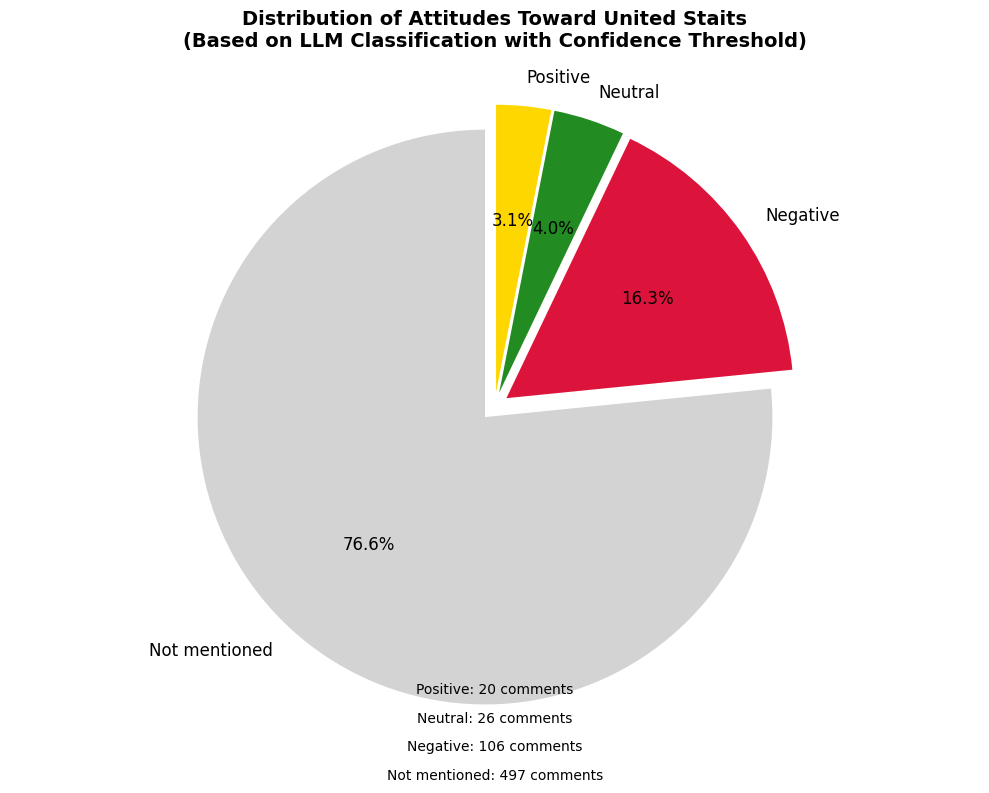

Attitude Distribution Summary:
Total comments: 649
Not mentioned: 497 comments (76.6%)
Negative: 106 comments (16.3%)
Neutral: 26 comments (4.0%)
Positive: 20 comments (3.1%)


In [55]:
title = 'Distribution of Attitudes Toward United Staits\n(Based on LLM Classification with Confidence Threshold)'
draw_attitude_distribution_diagram(title, 'us_attitude_category')

## 🇺🇸 Complete Attitude Analysis: United States

In [57]:
us_attitude_summary = get_cluster_summary(df_classified, 'us', 17)

/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less_equal
  return op(a, b)


In [59]:
presenter.present_dual_clusters(us_attitude_summary, 'US')


# 🇺🇸 Complete Attitude Analysis: US

<div style="text-align: center; background: linear-gradient(90deg, #28a74520, #dc354520); padding: 20px; border-radius: 10px; margin: 20px 0;">
<h2>Comprehensive Analysis of Positive vs Negative Attitude Clusters</h2>
</div>

---



# 🇺🇸 Attitude Analysis: US
## 👍 Positive 🔥 Cluster Analysis

<div style="background-color: #28a74515; padding: 15px; border-left: 4px solid #28a745; margin: 10px 0;">
<strong>Cluster Type:</strong> Positive Cluster<br>
<strong>Analysis Quality:</strong> Comprehensive reasoning provided
</div>

---

## 🧠 **AI Reasoning Summary**

<div style="padding: 15px; border-radius: 8px; margin: 15px 0; border-left: 3px solid #007bff;">
<em>I scanned the comments for stance markers toward the US and clustered the recurring rationales. Most comments defend or normalize US involvement/awareness in the Qatar strike, argue US guarantees did not fail, and frame Qatar as culpable for hosting Hamas. They justify cross-border strikes by citing US/UK precedents (Bin Laden, ISIS operations), invoke “don’t harbor terrorists” norms, and highlight US defensive actions (e.g., Patriot interception) to rebut the video’s claim of “empty” guarantees. The tone is assertive and mocking toward ceasefire narratives and critical of Qatar’s ties to Islamist groups. One dissenting comment calls the strike an insult to US sovereignty obligations, but the cluster majority leans pro-US, emphasizing counterterrorism legitimacy and strategic realism.</em>
</div>

---

## 🎯 **Key Insights**

**1.** Counterterrorism precedent is the core justification: citing the Bin Laden raid and Western strikes on ISIS to argue US awareness or support is normal and legitimate.

**2.** Harboring-terrorists norm: commenters claim states that host militant leaders forfeit immunity, shifting responsibility from the US to Qatar/Hamas.

**3.** US guarantees reframed: they say guarantees didn’t fail because Qatar wasn’t the target and/or US defenses engaged against Iran, preserving US credibility.

**4.** Hypocrisy framing: they argue critics apply a double standard to Israel/US versus similar Western counterterror actions.

**5.** Rhetorical style is assertive and mocking, using rhetorical questions, emojis, absolutes, and moral accusations against Qatar’s perceived duplicity.

---

## 📋 **Detailed Cluster Analysis**

<div style="padding: 15px; border-radius: 8px; line-height: 1.6;">
This cluster expresses a moderately positive attitude toward the US, primarily by reframing the Qatar incident through a counterterrorism and realpolitik lens that validates US behavior and credibility.

**What they believe:** 

**•** The US has a legitimate and established precedent for extraterritorial counterterrorism (e.g., Bin Laden raid, UK/US strikes on ISIS), so US awareness, enabling, or direct action is neither unusual nor discrediting.

**•** Qatar bears responsibility for consequences because it hosts, shelters, or funds Hamas and related Islamist networks; harboring terrorists voids expectations of absolute sanctuary.

**•** US security guarantees to Qatar are intact; the Israel and Iran incidents either did not target Qatar directly or were handled (citing US/Qatari air defense responses), thus not disproving US commitments.

**•** Strategic logic: the US will back allies against “genocidal radical Islamists,” and allowing/assisting targeted strikes can be consistent with broader US interests and regional stability.

**How they express it:** 

**•** Precedent-based analogies: frequent references to the Bin Laden operation and Western strikes on ISIS to normalize what happened in Doha.

**•** Normative rules-of-thumb: “don’t harbor terrorists” as a bright-line standard, implying the costs are predictable and justified.

**•** Accusations and moral charge: Qatar depicted as two-faced, a sponsor of terrorism/MB, “milking both cows,” thus forfeiting moral standing.

**•** Hypocrisy calls: pointing to double standards when Israel (or the US) is criticized for tactics other countries have used.

**•** Confident, mocking tone: laughter emojis at ceasefire talk; rhetorical questions to box the argument; categorical statements (“everyone understands,” “dead man walking”).

**Where they diverge:** 

**•** A minority view labels the strike an affront to US sovereignty commitments, but this is overshadowed by pro-US rationalizations.

**•** Some argue the US actively helped or warned; others say non-interdiction is consistent with guarantees since Qatar wasn’t the target.

Overall, the cluster sustains US credibility by asserting counterterror norms, shifting blame to Qatar/Hamas, and using Western precedent to delegitimize the video’s narrative of US failure.
</div>

---

## 💬 **Representative Quotes**

> **Quote 1:** *"US security guarantees didn't fail in either case. Neither attacks targeted Qatar, and they were allowed to happen on purpose by your own analysis."*


> **Quote 2:** *"If Cuba was hosting meetings with Al Qaida leaders in 2003, the US would have done the same thing, and would have been just as right to do so."*


> **Quote 3:** *"Only public outrage when the Jews do it, right?... US did it in Pakistan for Bin Laden, UK did it in Iraq for ISIS... but THIS is a problem?"*


---
<small>Analysis generated on 2025-09-18 17:20:30</small>


---



# 🇺🇸 Attitude Analysis: US
## 👎 Negative 🔥 Cluster Analysis

<div style="background-color: #dc354515; padding: 15px; border-left: 4px solid #dc3545; margin: 10px 0;">
<strong>Cluster Type:</strong> Negative Cluster<br>
<strong>Analysis Quality:</strong> Comprehensive reasoning provided
</div>

---

## 🧠 **AI Reasoning Summary**

<div style="padding: 15px; border-radius: 8px; margin: 15px 0; border-left: 3px solid #007bff;">
<em>The comments coalesce around distrust of the US, framed as enabler or director of Israel’s actions in Qatar. Viewers map the video’s technical inferences (in-flight refueling implying US detection/permission and Qatar’s air defenses not engaging) onto a broader narrative of US hegemony, proxy warfare via Israel, and unreliable security guarantees. They combine recent events (Doha strike, prior Iranian and Israeli strikes on Qatar) with historical grievances (Turkey/US embargo in 1974) to argue the US cannot be trusted as a protector or mediator. The tone ranges from analytical “cold geopolitics” to incendiary rhetoric, but the shared thrust is that US policy is duplicitous and subordinated to Israeli aims, motivating calls for decoupling, “multipolar” alignments, or an “Islamic NATO.” The intensity is moderated by several commenters couching claims as inference or speculation rather than certainty.</em>
</div>

---

## 🎯 **Key Insights**

**1.** Commenters internalize the video’s technical argument (tanker/refueling and US detection) as de facto proof of US complicity, reinforcing a long-standing narrative of American hegemony and proxy control via Israel.

**2.** Perceived failure of US security guarantees—after both Iranian and Israeli strikes—drives calls for strategic decoupling from Washington toward regional or multipolar alignments (Turkey/East, Islamic NATO).

**3.** Historical grievances (e.g., 1974 US-Turkey embargo) are invoked as precedent that American leverage and conditionality make US-made defense systems and promises unreliable.

**4.** The claim that Qatar hosted Hamas at US/Israel’s request amplifies accusations of duplicity, suggesting Washington facilitated a setup that later endangered negotiators.

**5.** Language ranges from ‘cold geopolitical’ analysis to inflammatory metaphors and absolutist distrust, but converges on the conclusion that the US cannot be trusted as protector or mediator.

---

## 📋 **Detailed Cluster Analysis**

<div style="padding: 15px; border-radius: 8px; line-height: 1.6;">
**•** Targeted attitude: Negative toward the US. Commenters see Washington as complicit—either greenlighting, facilitating, or at minimum knowingly allowing—the strike in Doha, thereby invalidating US security guarantees and mediation claims.

**•** Core beliefs/assumptions:

1) The US exercises decisive regional control and uses Israel as a proxy to do “dirty work.”

2) Technical realities (air-to-air refueling, US sensor coverage) make US awareness of the strike inevitable; non-engagement by Qatar’s defenses suggests US pressure.

3) US promises are unreliable; allies relying on American protection will be exposed, as seen in Qatar’s case and historical episodes (e.g., Turkey 1974).

4) Hosting Hamas in Qatar was done at US/Israeli request, underscoring perceived US duplicity in later targeting negotiators.

**•** Shared references: The video’s refueling/detection argument; reports that Qatar hosted Hamas at US/Israel’s behest; Trump-linked meeting preceding the strike; Patriot/AA systems “not working”; earlier Iranian and Israeli strikes on Qatar.

**•** Reasoning frameworks: Realist “hegemonic” analysis (“cold geopolitics”), guilt-by-capability (if the US could detect it, it must have allowed it), precedent-based distrust (embargoes, broken guarantees), and a multipolar re-alignment prescription (pivot to Turkey/East, Islamic NATO).

**•** Linguistic/rhetorical patterns: Absolutes (“cannot be trusted”), causal inevitability (“US in charge”), rhetorical questions (“How come the Patriot system did not work?”), capitalization for emphasis, metaphor/dehumanization (“dog,” “puppet”), and moral condemnation of “duplicitous” behavior. Some comments include conspiratorial or sectarian framing.

**•** Prescriptions: Eject US forces, reverse normalization with Israel, form regional defense blocs, treat violence/force as the “only language” the US/Israel “understand.”
</div>

---

## 💬 **Representative Quotes**

> **Quote 1:** *"I'd been unaware of the evidence of US collusion in the strike on Qatar. Absolutely devastating for US credibility."*


> **Quote 2:** *"The US cannot be trusted, it is a multipolar world, we need new alliences."*


> **Quote 3:** *"They are willing to do whatever they are green-lighted or even suggested to do by the US administration. The US is IN CHARGE of this conflict..."*


---
<small>Analysis generated on 2025-09-18 17:20:30</small>



---

# 🔍 **Cluster Comparison Summary**

<div style="display: flex; gap: 20px; margin: 20px 0;">

<div style="flex: 1; background-color: #28a74510; padding: 15px; border-radius: 8px;">
<h3 style="color: #28a745;">👍 Positive Cluster</h3>
<strong>Key Insights:</strong> 5<br>
<strong>Quotes:</strong> 3<br>
<strong>Analysis Quality:</strong> Comprehensive reasoning provided
</div>

<div style="flex: 1; background-color: #dc354510; padding: 15px; border-radius: 8px;">
<h3 style="color: #dc3545;">👎 Negative Cluster</h3>
<strong>Key Insights:</strong> 5<br>
<strong>Quotes:</strong> 3<br>
<strong>Analysis Quality:</strong> Comprehensive reasoning provided
</div>

</div>

## 🎯 **Key Contrasts**

### Core Justifications

- **Positive:** I scanned the comments for stance markers toward the US and clustered the recurring rationales. Most comments defend or normalize US involvement/awareness in the Qatar strike, argue US guarantees did ...
- **Negative:** The comments coalesce around distrust of the US, framed as enabler or director of Israel’s actions in Qatar. Viewers map the video’s technical inferences (in-flight refueling implying US detection/per...

### Representative Arguments

- **Positive:** *"US security guarantees didn't fail in either case. Neither attacks targeted Qatar, and they were allowed to happen on purpose by your own analysis."*
- **Negative:** *"I'd been unaware of the evidence of US collusion in the strike on Qatar. Absolutely devastating for US credibility."*

---


### Towards Qatar

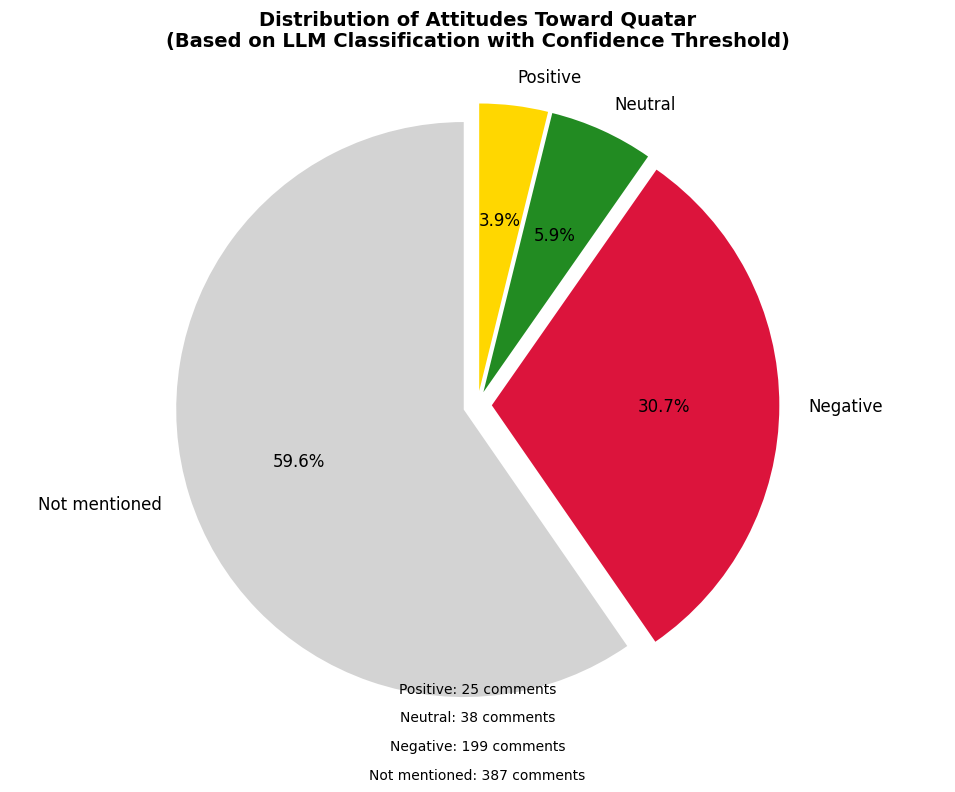

Attitude Distribution Summary:
Total comments: 649
Not mentioned: 387 comments (59.6%)
Negative: 199 comments (30.7%)
Neutral: 38 comments (5.9%)
Positive: 25 comments (3.9%)


In [60]:
title = 'Distribution of Attitudes Toward Quatar\n(Based on LLM Classification with Confidence Threshold)'
draw_attitude_distribution_diagram(title, 'quatar_attitude_category')

## 🇶🇦 Complete Attitude Analysis: Qatar

In [64]:
qatar_attitude_summary = get_cluster_summary(df_classified, 'qatar', 20)

In [66]:
presenter.present_dual_clusters(qatar_attitude_summary, 'Qatar')


# 🇶🇦 Complete Attitude Analysis: Qatar

<div style="text-align: center; background: linear-gradient(90deg, #28a74520, #dc354520); padding: 20px; border-radius: 10px; margin: 20px 0;">
<h2>Comprehensive Analysis of Positive vs Negative Attitude Clusters</h2>
</div>

---



# 🇶🇦 Attitude Analysis: Qatar
## 👍 Positive 🔥 Cluster Analysis

<div style="background-color: #28a74515; padding: 15px; border-left: 4px solid #28a745; margin: 10px 0;">
<strong>Cluster Type:</strong> Positive Cluster<br>
<strong>Analysis Quality:</strong> Comprehensive reasoning provided
</div>

---

## 🧠 **AI Reasoning Summary**

<div style="padding: 15px; border-radius: 8px; margin: 15px 0; border-left: 3px solid #007bff;">
<em>The comments consistently frame Qatar as a neutral mediator wronged by Israel (and, by implication, the US), emphasizing sovereignty violations and betrayal of established norms. Support for Qatar appears through:
- Affirmations of Qatar’s mediation role and neutrality (“peace talks hub,” “neutral territory”).
- The claim that the US requested Qatar host Hamas, making the strike unjust and duplicitous.
- Calls for Qatar to bolster its defenses and diversify away from US security dependence, showing protective, pro-Qatar prescriptions.
- Moral-legal framing (sovereignty, neutrality, “like bombing Switzerland”) and evidence citing (Spiegel, WSJ) to legitimize pro-Qatar positions.
Even when commenters criticize other actors, they do so to defend Qatar’s standing, safety, and credibility, reflecting a positive but not uncritical stance that urges strategic recalibration rather than blind support.</em>
</div>

---

## 🎯 **Key Insights**

**1.** Qatar is framed as a neutral mediator whose sovereignty and role were violated, strengthening sympathetic, pro-Qatar sentiment.

**2.** A central claim is that the US asked Qatar to host Hamas leaders, so striking Doha is seen as hypocrisy and betrayal.

**3.** Commenters use international-law and neutrality norms (“like bombing Switzerland”) to justify support for Qatar and condemn the strike.

**4.** There is a strong push for Qatar to diversify defense and tech away from the US (toward Turkey, Russia, China) due to perceived unreliability.

**5.** Cited media sources (Spiegel, WSJ) and operational speculation about radar/air-defense complicity lend an evidentiary veneer to the pro-Qatar narrative.

---

## 📋 **Detailed Cluster Analysis**

<div style="padding: 15px; border-radius: 8px; line-height: 1.6;">
This cluster views Qatar positively as a principled, neutral mediator that was punished for facilitating negotiations at the behest of the US. The dominant narrative is that Israel’s strike in Doha breached Qatar’s sovereignty, shattered norms that protect neutral venues, and undermined global trust in mediation. Many assert that the US either enabled or failed to prevent the strike—citing radar/air-defense blind spots, the Al-Udeid base’s likely awareness, and media references claiming Washington asked Qatar to host Hamas representatives. From this perspective, Qatar is a victim of great-power duplicity rather than a complicit host.

**Shared beliefs and assumptions:** 

**•** Qatar’s mediation is legitimate, longstanding, and valuable; Doha functions as neutral ground akin to Switzerland.

**•** The US requested Hamas’s Qatar presence to maintain negotiation channels; thus, punishing Qatar is unjust and counterproductive.

**•** Sovereignty and neutrality should be inviolable; targeting negotiators or their hosts is a red line.

**Information sources and reference points:** 

**•** Citations to Spiegel and a WSJ op-ed (via a Qatari ambassador) are used to substantiate the “US-requested hosting” claim.

**•** References to US operations history and earlier mediation precedents to contrast past respect for neutral forums vs. the current breach.

**Reasoning frameworks:** 

**•** International law and norms of diplomatic safety/neutrality.

**•** Realist security logic: US protection is unreliable, so Qatar should diversify defenses and alliances.

**•** Credibility logic: undermining Doha damages broader mediation (Gaza, Russia-Ukraine), eroding trust in both the US and Israel.

**Rhetorical patterns:** 

**•** Norm-violation language (“betrayal,” “backstabbing,” “violation of sovereignty”), analogies (“like bombing Switzerland”), and moral condemnation of hypocrisy.

**•** Pragmatic prescriptions: acquire non-US air defenses (S-400, Turkish systems), consider Chinese tech, and reduce reliance on US guarantees.

**•** Occasional sarcasm and pejoratives toward Israeli leadership; one Israeli commenter calls for apology and compensation, reinforcing the sovereignty frame.

Overall, the cluster’s positive attitude toward Qatar manifests as empathy for a wronged mediator, defense of its neutrality and sovereignty, and supportive calls for strategic autonomy—while sharply criticizing Israel’s actions and questioning US credibility.
</div>

---

## 💬 **Representative Quotes**

> **Quote 1:** *"Hamas was only in Qatar because the USA ASKED THEM TO HOST HAMAS, So we would have someone to negotiate with. They were bombed for doing what we asked them to do!"*


> **Quote 2:** *"Qatar is by far the most common place the west has conducted peace talks at for a long time now... Who would negotiate with assassins... Qatar is neutral territory."*


> **Quote 3:** *"I am not at all happy with this strike... it is my perspective that this is a profound insult to the United States, nevermind the clear violation of Qatar sovereignty."*


---
<small>Analysis generated on 2025-09-18 17:27:39</small>


---



# 🇶🇦 Attitude Analysis: Qatar
## 👎 Negative 🔥 Cluster Analysis

<div style="background-color: #dc354515; padding: 15px; border-left: 4px solid #dc3545; margin: 10px 0;">
<strong>Cluster Type:</strong> Negative Cluster<br>
<strong>Analysis Quality:</strong> Comprehensive reasoning provided
</div>

---

## 🧠 **AI Reasoning Summary**

<div style="padding: 15px; border-radius: 8px; margin: 15px 0; border-left: 3px solid #007bff;">
<em>The comments consistently frame Qatar as a bad-faith actor: a financier and host of Islamist groups (especially Hamas), a propagandist via soft power (Al Jazeera, Western academia/media), and a duplicitous “mediator” who plays all sides while enabling terrorism. The Israel strike in Doha is used as vindication—either Qatar “deserved” it for sheltering Hamas or its air-defense nonresponse implies complicity or impotence. Commenters lean on familiar Gulf narratives (Qatar vs UAE/Saudi over political Islam), cite specific talking points (Muslim Brotherhood ties, “second-largest funder after Iran,” “$30B propaganda”), and deploy moral language (terror exporter, nucleus of extremism, hypocrisy on sovereignty). Rhetorically, they use cause-and-effect (“harbor terrorists → expect retaliation”), delegitimization (“not neutral, terrorist safe haven”), and sarcasm. The video’s themes—Qatar’s mediation credibility collapsing, possible US tacit approval, and non-engaged air defenses—serve as confirmation for preexisting suspicions about Qatar’s role and motives.</em>
</div>

---

## 🎯 **Key Insights**

**1.** Commenters reject Qatar’s neutrality, asserting that funding and sheltering Hamas disqualify it from mediating and make it complicit in violence.

**2.** The Israel strike in Doha is interpreted as predictable retribution for hosting Hamas and as evidence of Qatar’s hypocrisy on sovereignty and security.

**3.** Soft power narratives (Al Jazeera, campus/media funding, alleged bribery) underpin a belief that Qatar spreads pro-Islamist influence globally.

**4.** The cluster maps Qatar onto the political Islam camp in the Gulf divide (vs UAE/Saudi), using that frame to explain its policies and alliances.

**5.** Rhetorically, the group relies on moral condemnation, sarcasm, and simple cause-and-effect logic (“harbor terrorists → expect consequences”) to justify a negative stance.

---

## 📋 **Detailed Cluster Analysis**

<div style="padding: 15px; border-radius: 8px; line-height: 1.6;">
**Attitude profile:** 

**•** Direction and intensity: Negative, moderate. While some posts use harsh language, the core throughline is a structured critique of Qatar’s behavior rather than calls for direct harm.

**•** Target: Qatar’s state policy and elite decision-making (funding/hosting Islamist groups, foreign influence operations, duplicity in mediation).

**Core claims and assumptions:** 

1) Qatar is a sponsor/enabler of Hamas and broader political Islamism.

**•** Repeated assertions that Doha funds, shelters, or protects Hamas; links to the Muslim Brotherhood and Al-Qaeda are invoked to generalize Qatar’s Islamist footprint.

2) Qatar’s mediator image is a façade.

**•** Hosting Hamas while brokering talks is cast as “playing all sides,” rendering Qatar non-neutral and complicit in violence.

**3) Hypocrisy and consequences:** 

**•** Commenters claim Qatar condemns sovereignty violations only when targeted itself, yet tolerated/financed violations by groups it backs. Therefore, Israel’s strike is portrayed as an unsurprising or “deserved” consequence.

**4) Soft power and influence operations:** 

**•** Al Jazeera, alleged massive funding of Western academia/media, and bribery narratives are cited to argue Qatar shapes discourse to shield or advance Islamist agendas.

**5) Regional alignment:** 

**•** The Qatar vs UAE/Saudi divide is used to situate Qatar on the “political Islam” side, aligning it with Iran/Hamas against states promoting “contained” or state-controlled Islam.

**Links to the video context:** 

**•** The video’s points about air defenses not activating and possible US tacit approval are seized upon to argue Doha knew, was pressured, or is weak—undermining Qatar’s claims of sovereignty and security competence.

**•** The strike’s impact on mediation is used to argue Qatar’s broker role was always compromised and now exposed.

**•** Speculation about US detection/approval feeds the view that Qatar cannot rely on US protection and has overplayed its double game.

**Rhetorical and linguistic patterns:** 

**•** Moralizing labels: “terror exporter,” “nucleus of extremism,” “safe haven” to delegitimize state intent.

**•** Causal retribution framing: “harbor terrorists → accept retaliation.”

**•** Sarcasm and mockery aimed at “neutral mediator” claims; ridicule of Qatar’s outrage.

**•** Use of numbers and specific entities (e.g., “$30B,” Al Jazeera, Muslim Brotherhood) to create an impression of evidence-backed critique.

**•** Appeals to regional geopolitics (UAE/Saudi vs Qatar) to ground claims in a broader ideological struggle.

**Why these commenters converge:** 

**•** Shared belief that political Islam is the driver of regional instability and that Qatar is its key patron.

**•** Prior exposure to Gulf crisis narratives and Western debates about Qatar’s influence operations.

**•** The Doha strike acts as a salient event that “proves” long-held suspicions, reducing Qatar’s plausible deniability as a neutral mediator.

**•** Consistent reasoning that legitimacy depends on clear alignment (“pick a side”), and “fence-sitting” invites retaliation.
</div>

---

## 💬 **Representative Quotes**

> **Quote 1:** *""Qatar has sponsored/sheltered Hamas for years, so bears some of the guilt for the October 7 strike and consequences. They are playing all sides of the fence.""*


> **Quote 2:** *""'Qatar has been the center of negotiations.'  😂😂😂 That's one way to say terrorist safe haven."*


> **Quote 3:** *"When you offer safe harbor to groups like Hamas, you can't complain when their enemies take action."*


---
<small>Analysis generated on 2025-09-18 17:27:39</small>



---

# 🔍 **Cluster Comparison Summary**

<div style="display: flex; gap: 20px; margin: 20px 0;">

<div style="flex: 1; background-color: #28a74510; padding: 15px; border-radius: 8px;">
<h3 style="color: #28a745;">👍 Positive Cluster</h3>
<strong>Key Insights:</strong> 5<br>
<strong>Quotes:</strong> 3<br>
<strong>Analysis Quality:</strong> Comprehensive reasoning provided
</div>

<div style="flex: 1; background-color: #dc354510; padding: 15px; border-radius: 8px;">
<h3 style="color: #dc3545;">👎 Negative Cluster</h3>
<strong>Key Insights:</strong> 5<br>
<strong>Quotes:</strong> 3<br>
<strong>Analysis Quality:</strong> Comprehensive reasoning provided
</div>

</div>

## 🎯 **Key Contrasts**

### Core Justifications

- **Positive:** The comments consistently frame Qatar as a neutral mediator wronged by Israel (and, by implication, the US), emphasizing sovereignty violations and betrayal of established norms. Support for Qatar app...
- **Negative:** The comments consistently frame Qatar as a bad-faith actor: a financier and host of Islamist groups (especially Hamas), a propagandist via soft power (Al Jazeera, Western academia/media), and a duplic...

### Representative Arguments

- **Positive:** *"Hamas was only in Qatar because the USA ASKED THEM TO HOST HAMAS, So we would have someone to negotiate with. They were bombed for doing what we asked them to do!"*
- **Negative:** *""Qatar has sponsored/sheltered Hamas for years, so bears some of the guilt for the October 7 strike and consequences. They are playing all sides of the fence.""*

---


### Towards Hamas

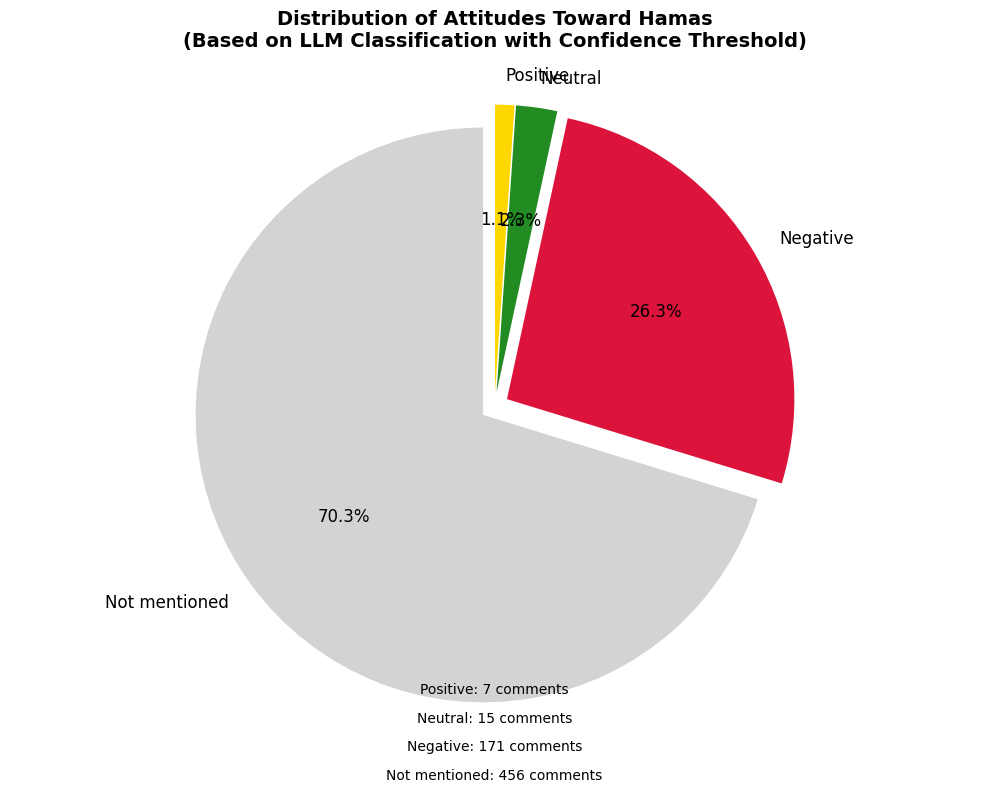

Attitude Distribution Summary:
Total comments: 649
Not mentioned: 456 comments (70.3%)
Negative: 171 comments (26.3%)
Neutral: 15 comments (2.3%)
Positive: 7 comments (1.1%)


In [67]:
title = 'Distribution of Attitudes Toward Hamas\n(Based on LLM Classification with Confidence Threshold)'
draw_attitude_distribution_diagram(title, 'hamas_attitude_category')

## Complete Attitude Analysis: Hamas

In [77]:
hamas_attitude_summary = get_cluster_summary(df_classified, 'hamas', 5)

In [78]:
presenter.present_dual_clusters(hamas_attitude_summary, 'hamas')


# 🎯 Complete Attitude Analysis: hamas

<div style="text-align: center; background: linear-gradient(90deg, #28a74520, #dc354520); padding: 20px; border-radius: 10px; margin: 20px 0;">
<h2>Comprehensive Analysis of Positive vs Negative Attitude Clusters</h2>
</div>

---



# 🎯 Attitude Analysis: hamas
## 👍 Positive 🔥 Cluster Analysis

<div style="background-color: #28a74515; padding: 15px; border-left: 4px solid #28a745; margin: 10px 0;">
<strong>Cluster Type:</strong> Positive Cluster<br>
<strong>Analysis Quality:</strong> Comprehensive reasoning provided
</div>

---

## 🧠 **AI Reasoning Summary**

<div style="padding: 15px; border-radius: 8px; margin: 15px 0; border-left: 3px solid #007bff;">
<em>The comments consistently defend and legitimize Hamas in the context of the Doha strikes and stalled negotiations. They position Hamas as a willing negotiator—even to the point of accepting dissolution—and as a victim of Israeli/US aggression and Arab-state complicity. They challenge mainstream narratives by reframing Israeli-held captives as “prisoners of war,” blaming Israel for collapsing the January 2025 ceasefire, and asserting that the assassination attempt in Doha deliberately sabotaged an emerging deal. Their reasoning aligns closely with the video’s framing: that the strike crippled talks, exposed US complicity or foreknowledge, and revealed regional actors (Qatar, Saudi, Jordan) as unable or unwilling to protect the process. Linguistically, they use rhetorical questions, moral absolutes (“genocide”), and certainty claims (“the world now knows”), and infer betrayal via airspace access and non-activation of defenses. The attitude is positive toward Hamas but expressed through exculpation and victimhood framing rather than overt glorification, hence moderate intensity.</em>
</div>

---

## 🎯 **Key Insights**

**1.** Commenters reframe Hamas as a legitimate negotiating actor—claiming it agreed even to dissolution under neutral governance—thereby shifting blame for failed talks onto Israel and the US.

**2.** They recast captives as “prisoners of war,” a legal-moral strategy to normalize Hamas as a belligerent and reject the “hostage-taker” narrative.

**3.** The Doha strike is interpreted as deliberate sabotage of a nearing deal, with alleged US complicity and Arab-state betrayal (airspace access, silent air defenses).

**4.** Moral absolutism (“genocide,” “innocent”) and rhetorical questions are used to indict Israel/US and shame regional governments, intensifying sympathy for Hamas.

**5.** Information cues in the video (tanker support, Qatar’s defenses, Trump’s paper) serve as shared reference points that reinforce a unified spoiler narrative.

---

## 📋 **Detailed Cluster Analysis**

<div style="padding: 15px; border-radius: 8px; line-height: 1.6;">
**This cluster portrays Hamas as a legitimate political/military actor engaged in good-faith negotiations, unjustly targeted in a way that sabotaged peace prospects. Commenters assert:** 

**•** Hamas showed maximal flexibility, allegedly agreeing to terms that would dissolve itself in exchange for neutral international governance in Gaza.

**•** Israel (and by extension the US) is the true spoiler—collapsing the January 2025 ceasefire, obstructing prisoner/ceasefire arrangements, and attempting to assassinate negotiators in Doha.

**•** Regional governments (Qatar, Saudi Arabia, Jordan) are complicit or ineffectual—either “selling out” Hamas by allowing overflight and failing to activate defenses, or unable to protect the mediation venue.

**Underlying beliefs and assumptions:** 

**•** Hamas is a legitimate belligerent; captives are “prisoners of war,” not “hostages,” implying lawful combatant status and shifting moral blame.

**•** Israel is perpetrating “genocide,” making any strikes intrinsically illegitimate and making Hamas members “innocent” victims when targeted abroad.

**•** US involvement is duplicitous—alleged tanker/refueling support or intelligence sharing—and Washington’s mediation posture masks complicity.

**Shared references and narratives:** 

**•** The Doha strike as a turning point that “shot at the proposal” itself.

**•** The notion that Trump’s intervention/paper preceded or framed the episode.

**•** Claims about Saudi/Jordanian airspace access and Qatar’s silent air defenses as evidence of foreknowledge or pressure.

**Linguistic/rhetorical patterns:** 

**•** Rhetorical questions challenging omissions (“You wanna mention…?”).

**•** Moral absolutism and condemnation (“genocidal army,” “shameful”).

**•** Certainty language (“the world now knows”) and causal inferences from circumstantial details (air defenses, overflight).

**•** Inversion of mainstream narratives (Hamas as peacemaker; Israel/US/Arab states as spoilers).

**Reasoning framework:** 

**•** Attribution of responsibility for failed talks to Israel/US/regional allies, not Hamas.

**•** Legal-moral reframing (POWs vs. hostages) to legitimize Hamas and delegitimize Israeli actions.

**•** Emphasis on evidence that fits the betrayal/complicity thesis; dismissing claims that “neither side” has leverage by asserting Hamas already conceded maximally.

Overall, the cluster expresses moderately positive sentiment toward Hamas by defending its intentions and casting it as a victim of external sabotage, rather than by celebrating its violence or ideology.
</div>

---

## 💬 **Representative Quotes**

> **Quote 1:** *"Hamas has agreed to terms that actually dissolve Hamas in exchange for governance by neutral international governance of the Gaza Strip."*


> **Quote 2:** *"You wanna mention that there are no more hostages left in Gaza, only prisoners of war?"*


> **Quote 3:** *"So shameful to help the genocidal army to conduct attack the innocent Hamas individuals."*


---
<small>Analysis generated on 2025-09-18 17:38:54</small>


---



# 🎯 Attitude Analysis: hamas
## 👎 Negative 🔥 Cluster Analysis

<div style="background-color: #dc354515; padding: 15px; border-left: 4px solid #dc3545; margin: 10px 0;">
<strong>Cluster Type:</strong> Negative Cluster<br>
<strong>Analysis Quality:</strong> Comprehensive reasoning provided
</div>

---

## 🧠 **AI Reasoning Summary**

<div style="padding: 15px; border-radius: 8px; margin: 15px 0; border-left: 3px solid #007bff;">
<em>The comments consistently condemn Hamas, framing its actions (October 7 and hostage-taking) as criminal and justifying strikes on its leadership even outside Gaza. They also connect Hamas’s presence in Qatar to perceived impunity, arguing “no safe havens.” The tone includes moral-legal language (“war crime”), retributive logic (“must be punished”), and some sarcasm, with one commenter adding a humanitarian caveat about avoiding civilian casualties—hence a “moderate” rather than “strong” intensity.</em>
</div>

---

## 🎯 **Key Insights**

**1.** Shared premise: Hamas’s October 7 attack and ongoing hostage-taking are war crimes that justify punitive, leadership-focused strikes.

**2.** Belief that Qatar’s hosting of Hamas created illegitimate ‘safe havens,’ so consequences for both Hamas and its protectors are warranted.

**3.** View that Hamas negotiates in bad faith (‘stalling’), weakening the case for ceasefire talks and strengthening calls for coercive measures.

**4.** Rhetorical patterns include moral-legal framing, causality (‘harboring → consequences’), sarcasm, and imperative language.

**5.** Some nuance persists: endorsement of targeting Hamas is coupled with expectations to avoid civilian casualties and provide compensation when harm occurs.

---

## 📋 **Detailed Cluster Analysis**

<div style="padding: 15px; border-radius: 8px; line-height: 1.6;">
This cluster expresses a shared, negative view of Hamas grounded in moral and legal condemnation and a belief in consequential accountability. Commenters cite October 7 and ongoing hostage-taking as core evidence that Hamas deserves punishment and that targeting its leadership is legitimate, even beyond Gaza. They argue that harboring Hamas in Qatar has fostered impunity; therefore, Doha cannot be a protected sanctuary and “harboring terrorists has consequences.”

**The group’s reasoning framework is retributive and deterrence-focused:** war crimes (hostage-taking) demand punitive action to end safe havens and enforce consequences. Several commenters also distrust Hamas’s negotiation posture, portraying ceasefire talks as stalling tactics that validate harder measures against leadership.

**Linguistically, they use:** 

**•** Moral-legal labeling (“war crime,” “terrorist”)

**•** Causality framing (“harboring → consequences”)

**•** Sarcasm and corrective reframing (retitling the video’s premise)

**•** Imperatives and certainty (“must be punished,” “no safe havens”)

**•** Limited dehumanizing jabs (“Don’t shed tears for them”), though not pervasive

**While most endorse striking Hamas leaders, one commenter introduces a normative constraint:** minimize civilian harm and compensate victims, indicating support for targeted action rather than indiscriminate force. Overall, the cluster rejects the video’s “red line” framing, reframing the strike as the predictable result of hosting Hamas and of Hamas’s own actions.
</div>

---

## 💬 **Representative Quotes**

> **Quote 1:** *"Hamas and Qatar were only stalling. They rejected generous terms... Hostage taking is a war crime and must be punished."*


> **Quote 2:** *"Qatar has sponsored/sheltered Hamas for years, so bears some of the guilt for the October 7 strike and consequences."*


> **Quote 3:** *"I 100% support going after Hamas's leadership - f any safe heavens... but if its in a foreign country, no one else can be killed."*


---
<small>Analysis generated on 2025-09-18 17:38:54</small>



---

# 🔍 **Cluster Comparison Summary**

<div style="display: flex; gap: 20px; margin: 20px 0;">

<div style="flex: 1; background-color: #28a74510; padding: 15px; border-radius: 8px;">
<h3 style="color: #28a745;">👍 Positive Cluster</h3>
<strong>Key Insights:</strong> 5<br>
<strong>Quotes:</strong> 3<br>
<strong>Analysis Quality:</strong> Comprehensive reasoning provided
</div>

<div style="flex: 1; background-color: #dc354510; padding: 15px; border-radius: 8px;">
<h3 style="color: #dc3545;">👎 Negative Cluster</h3>
<strong>Key Insights:</strong> 5<br>
<strong>Quotes:</strong> 3<br>
<strong>Analysis Quality:</strong> Comprehensive reasoning provided
</div>

</div>

## 🎯 **Key Contrasts**

### Core Justifications

- **Positive:** The comments consistently defend and legitimize Hamas in the context of the Doha strikes and stalled negotiations. They position Hamas as a willing negotiator—even to the point of accepting dissolutio...
- **Negative:** The comments consistently condemn Hamas, framing its actions (October 7 and hostage-taking) as criminal and justifying strikes on its leadership even outside Gaza. They also connect Hamas’s presence i...

### Representative Arguments

- **Positive:** *"Hamas has agreed to terms that actually dissolve Hamas in exchange for governance by neutral international governance of the Gaza Strip."*
- **Negative:** *"Hamas and Qatar were only stalling. They rejected generous terms... Hostage taking is a war crime and must be punished."*

---


## Insightfulness distribution

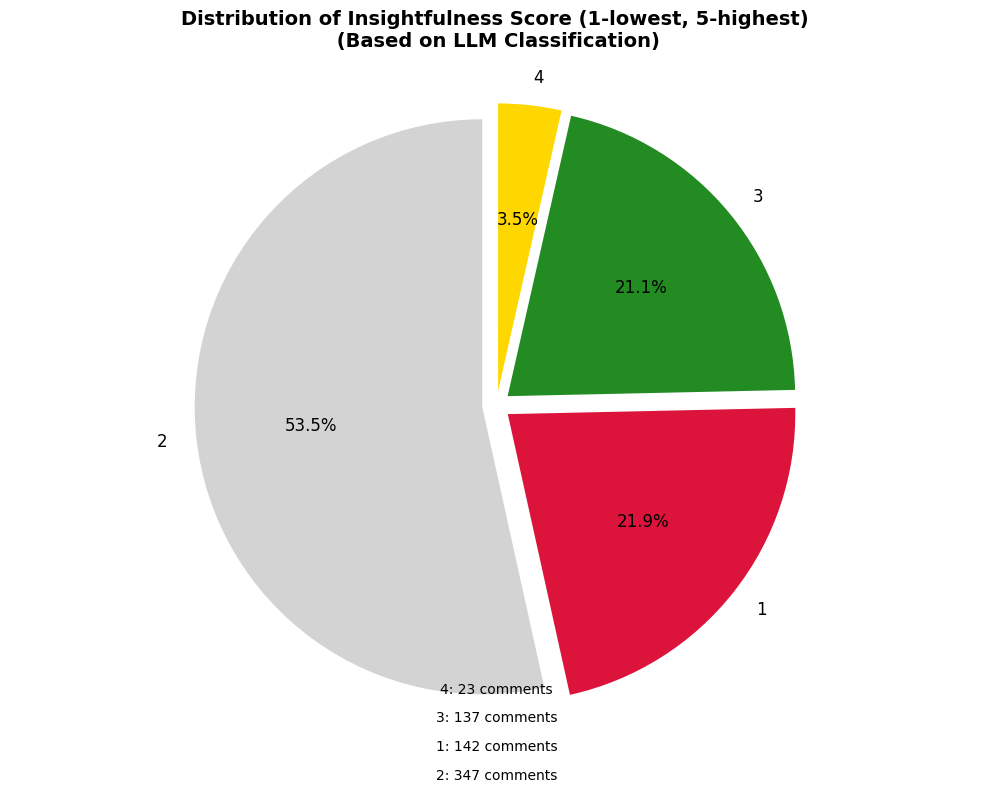

Attitude Distribution Summary:
Total comments: 649
2: 347 comments (53.5%)
1: 142 comments (21.9%)
3: 137 comments (21.1%)
4: 23 comments (3.5%)


In [79]:
title = 'Distribution of Insightfulness Score (1-lowest, 5-highest)\n (Based on LLM Classification)'
draw_attitude_distribution_diagram(title, 'insightfulness_score')

## Emotional score distribution

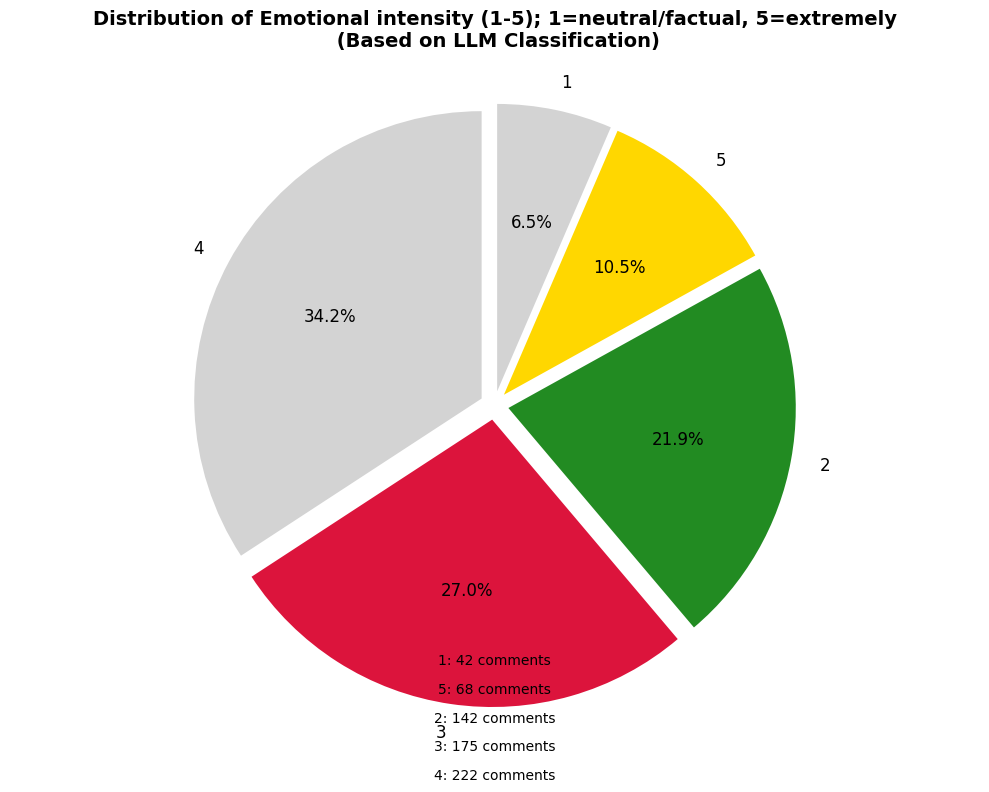

Attitude Distribution Summary:
Total comments: 649
4: 222 comments (34.2%)
3: 175 comments (27.0%)
2: 142 comments (21.9%)
5: 68 comments (10.5%)
1: 42 comments (6.5%)


In [80]:
title = 'Distribution of Emotional intensity (1-5); 1=neutral/factual, 5=extremely\n (Based on LLM Classification)'
draw_attitude_distribution_diagram(title, 'emotional_score')

## Intelligence score score distribution

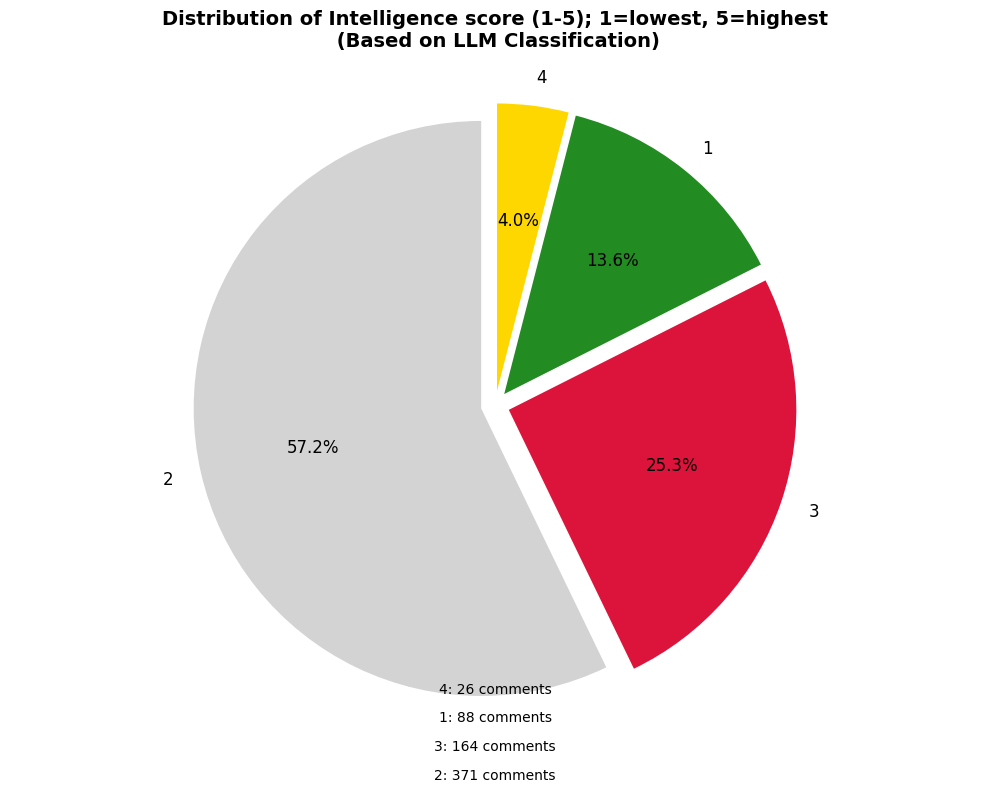

Attitude Distribution Summary:
Total comments: 649
2: 371 comments (57.2%)
3: 164 comments (25.3%)
1: 88 comments (13.6%)
4: 26 comments (4.0%)


In [81]:
title = 'Distribution of Intelligence score (1-5); 1=lowest, 5=highest\n (Based on LLM Classification)'
draw_attitude_distribution_diagram(title, 'intelligence_score')

## Likes distribution historgam
Let's take a look at likes distribution so we can draw a border between relevant comments based on number of likes and the rest that needs to be checked by LLM

In [82]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for better-looking plots
plt.style.use('default')
sns.set_palette("husl")

# Assuming your DataFrame is called 'df'
# If it has a different name, replace 'df' with your DataFrame variable name

# =============================================================================
# METHOD 4: Customizable Histogram Function
# =============================================================================

def create_likes_histogram(df, bins=30, figsize=(10, 6), color='skyblue', 
                          show_stats=True, title="Distribution of Likes"):
    """
    Create a customizable histogram for likes data.
    
    Parameters:
    - df: DataFrame with 'likes' column
    - bins: Number of bins for histogram
    - figsize: Figure size (width, height)
    - color: Histogram color
    - show_stats: Whether to show statistics on plot
    - title: Plot title
    """
    # =============================================================================
    # METHOD 5: Histogram by Ranges
    # =============================================================================
    
    # Create histogram with specific ranges
    plt.figure(figsize=(12, 6))
    
    # Define like ranges
    ranges = [(0, 0), (1, 5), (6, 10), (11, 20), (21, 50), (51, float('inf'))]
    range_labels = ['0 likes', '1-5 likes', '6-10 likes', '11-20 likes', '21-50 likes', '50+ likes']
    range_counts = []
    
    for min_val, max_val in ranges:
        if max_val == float('inf'):
            count = (df['likes'] >= min_val).sum()
        else:
            count = ((df['likes'] >= min_val) & (df['likes'] <= max_val)).sum()
        range_counts.append(count)
    
    # Create bar plot for ranges
    plt.subplot(1, 2, 1)
    bars = plt.bar(range_labels, range_counts, color='lightcoral', alpha=0.7, edgecolor='black')
    plt.title('Likes Distribution by Ranges')
    plt.xlabel('Like Ranges')
    plt.ylabel('Number of Comments')
    plt.xticks(rotation=45)

    # Add value labels on bars
    for bar, count in zip(bars, range_counts):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                 str(count), ha='center', va='bottom')
    
    # =============================================================================
    # METHOD 6: Compare Likes vs Replies
    # =============================================================================
    
    
    plt.subplot(1, 2, 2)
    plt.scatter(df['likes'], df['replies'], alpha=0.6, color='purple')
    plt.xlabel('Number of Likes')
    plt.ylabel('Number of Replies')
    plt.title('Likes vs Replies Relationship')
    plt.grid(True, alpha=0.3)
    
    # Add correlation coefficient
    correlation = df['likes'].corr(df['replies'])
    plt.text(0.05, 0.95, f'Correlation: {correlation:.3f}', 
             transform=plt.gca().transAxes, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    print("\n🎯 Quick Insights:")
    print(f"• Most comments ({(df['likes'] == 0).mean()*100:.1f}%) have 0 likes")
    print(f"• Average likes per comment: {df['likes'].mean():.1f}")
    print(f"• Top 10% of comments have ≥{df['likes'].quantile(0.9):.0f} likes")
    print(f"• Correlation between likes and replies: {df['likes'].corr(df['replies']):.3f}")


🎯 Quick Insights:
• Most comments (66.6%) have 0 likes
• Average likes per comment: 12.4
• Top 10% of comments have ≥6 likes
• Correlation between likes and replies: 0.897


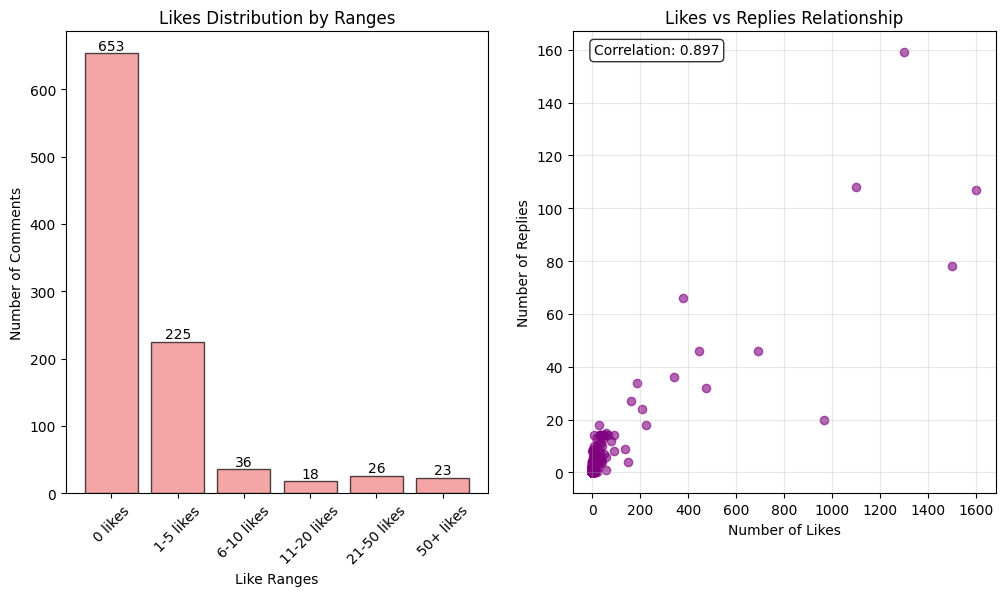

In [83]:
create_likes_histogram(df_unclassified)